<a href="https://colab.research.google.com/github/rodrigohaddad/RNSP/blob/main/experiments/WiSARD_Encoding_Real_Value_Inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wisardpkg
!git clone https://gist.github.com/1fe5c78be9a5ec2d507e8118e2c99740.git
!mv 1fe5c78be9a5ec2d507e8118e2c99740/*.py ./
!rm -rf ./1fe5c78be9a5ec2d507e8118e2c99740

In [ ]:
import wisardpkg as wp

import numpy as np

from ipywidgets import fixed, interact_manual

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 80

from encoders import ThermometerEncoder, CircularThermometerEncoder, FloatBinaryEncoder, process_input, Morph, CodeWord, NeighborsSuffix, MockNeighborsSuffix
from datagen import linearly_separable_dataset, sinusoidal_dataset, radially_separable_dataset, sample_mental_image
from wisardviz import plot_decision_boundary, classifier_testbed, plot_imagined_points

# WiSARD for Real Values Inputs

## 1. Introduction

The WiSARD family of models is usually exemplified with classification tasks over images. However, the experience with other machine learning schemes have created the expectation that models be able to handle inputs in the form of real valued vectors. How can we achieve that if RAM discriminators expect to receive as input binary strings in order to address its constituent RAM neurons?

The obvious answer to this challenge seems to be that we need to convert our inputs of interest to binary strings, but how should we do that?

## 2. Encoding Schemes

### 2.1. Thermometer encoder

This binary enconder is suitable for situations where we can stablish a minimum and maximum for the variable we wish to discretize. We divide this range into $N$ intervals. The encoded output is a $N$-bit binary string, $S$, where $S_i$ represents the value of the $i$-th position, $i \in [0, N-1]$. If $V$ is the variable we wish to encode, $M$ is the maximum and $m$, the minimum, then

$$
S_i = \begin{cases}
  1 & \text{if} \quad V > m + i \times \frac{M - m}{N}\\
  0 & \text{otherwise}
\end{cases}
$$



Thermometer can handle real values:

In [ ]:
thermometer = ThermometerEncoder(minimum=0, maximum=1, resolution=10)

In [ ]:
thermometer.encode(0.16)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
thermometer.encode(0.21)

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
thermometer.encode(0.0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
thermometer.encode(0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

and real vectors:

In [ ]:
thermometer.encode([0.16, 0.33])

array([[1, 1],
       [1, 1],
       [0, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]])

### 2.2. Circular Thermometer

This encoding works in a similar manner as the previous one but avoids varying the number of activated bits. Instead of filling the thermometer as the variable of interest moves closer to the maximum of the range, the circular encoding has a constant number of contigous activated bits and shifts this block to the right.

Again, we can handle scalars, vectors and collections of vectors as inputs:

In [ ]:
circ_thermo = CircularThermometerEncoder(0.0, 1.0, 11)

In [ ]:
circ_thermo.encode(0.2)

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=uint8)

In [ ]:
circ_thermo.encode(0.0)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
circ_thermo.encode(0.9)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [ ]:
pattern = circ_thermo.encode([[0.0, 0.10001], [0.21, 0.31]])

In [ ]:
pattern[:, :, 0]

array([[1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=uint8)

In [ ]:
pattern[:, :, 1]

array([[0, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [0, 0],
       [0, 0]], dtype=uint8)

We can also decode the pattern back (with loss of information):

In [ ]:
circ_thermo.decode(pattern)

array([[0. , 0.1],
       [0.2, 0.3]])

There is still an unattended problem: the WiSARD models expect single-dimensional arrays as input. Therefore, we need to reshape the aforementioned results:

In [ ]:
def flatten(X, column_major=True):
  X = np.asarray(X)
  order = 'F' if column_major else 'C'

  if X.ndim < 2:
    return X
  elif X.ndim == 2:
    return X.ravel(order=order)

  return np.asarray([X[:, :, i].ravel(order=order) for i in range(X.shape[2])])

In [ ]:
flatten(thermometer.encode([0.16, 0.33]), column_major=False)

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## 3. Can the WiSARD Handle binary classification in 2D euclidean space?

### 3.1 A linearly separable case study

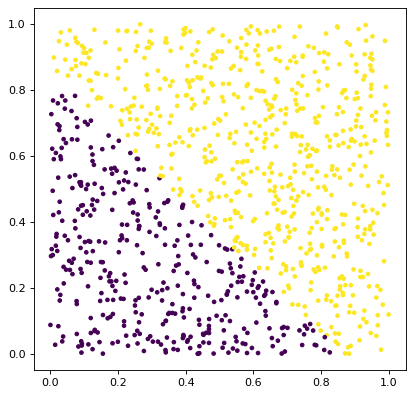

In [ ]:
X_lin, y_lin = linearly_separable_dataset(1000, seed=13)

plt.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, s=10)

**Finally**, shall we test how the WiSARD fares against the dataset?

In [ ]:
@interact_manual(
    seed=fixed(1),
    tuple_size=(2, 64),
    resolution=(8, 256),
    noise=(0.0, 0.5, 0.01))
def test_linear_classifier(seed, tuple_size=16, resolution=64, noise=0.0):
    X_lin, y_lin = linearly_separable_dataset(1000, seed=seed)
    
    classifier_testbed(
        X_lin,
        y_lin,
        tuple_size=tuple_size,
        noise=noise,
        encoders={
            'Simple encoding': ThermometerEncoder(0.0, 1.0, resolution),
            'Circular encoding': CircularThermometerEncoder(0.0, 1.0, resolution, wrap=True)
        },
        seed=seed,
        bleaching=True,
        layout='row',
        subplot_size=(8, 8),
        mental_images=False
    )

interactive(children=(IntSlider(value=16, description='tuple_size', max=64, min=2), IntSlider(value=64, descri…

### A "wiggly" case-study

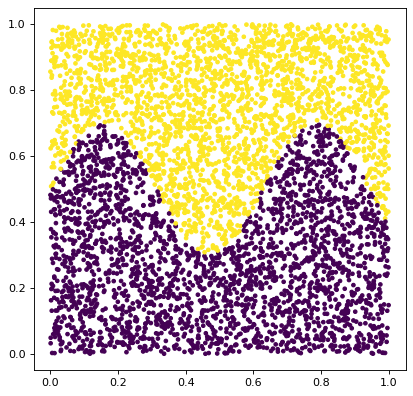

In [ ]:
X_wig, y_wig = sinusoidal_dataset(5000, seed=1)

plt.scatter(X_wig[:, 0], X_wig[:, 1], c=y_wig, s=10)

In [ ]:
@interact_manual(
    seed=fixed(1),
    tuple_size=(2, 64),
    resolution=(8, 256),
    noise=(0.0, 0.5, 0.01))
def test_wiggly_classifier(seed, tuple_size=16, resolution=64, noise=0.0):
    X_wig, y_wig = sinusoidal_dataset(1000, seed=seed)
    
    classifier_testbed(
        X_wig,
        y_wig,
        tuple_size=tuple_size,
        noise=noise,
        encoders={
            'Simple encoding': ThermometerEncoder(0.0, 1.0, resolution),
            'Circular encoding': CircularThermometerEncoder(0.0, 1.0, resolution, wrap=True)
        },
        seed=seed,
        layout='row',
        subplot_size=(5, 5),
        mental_images=False
    )

interactive(children=(IntSlider(value=16, description='tuple_size', max=64, min=2), IntSlider(value=64, descri…

### 3.3. A radially separable case-study

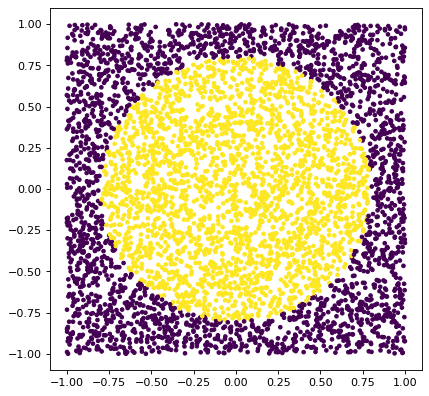

In [ ]:
X_r, y_r = radially_separable_dataset(5000, radius=np.sqrt(2/np.pi), seed=17)

plt.scatter(X_r[:, 0], X_r[:, 1], c=y_r, s=10)

In [ ]:
@interact_manual(
    seed=fixed(1),
    tuple_size=(2, 64),
    resolution=(8, 256),
    noise=(0.0, 0.5, 0.01))
def test_nonlinear_classifier(seed, tuple_size=16, resolution=64, noise=0.0):
    X_r, y_r = radially_separable_dataset(1000, radius=np.sqrt(2/np.pi), seed=seed)
    
    classifier_testbed(
        X_r,
        y_r,
        tuple_size=tuple_size,
        noise=noise,
        encoders={
            'Simple encoding': ThermometerEncoder(-1.0, 1.0, resolution),
            'Circular encoding': CircularThermometerEncoder(-1.0, 1.0, resolution, wrap=True)
        },
        seed=seed,
        layout='row',
        mental_images=False
    )

interactive(children=(IntSlider(value=16, description='tuple_size', max=64, min=2), IntSlider(value=64, descri…